In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from scipy import special
import sympy
from typing import List, Dict, Any

params = {
    'figure.figsize': (8.5, 6.5),
    'font.style': 'normal',
    'axes.labelsize': 25,
    'font.size': 16,
    'legend.fontsize': 11,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 8,
    'ytick.major.size': 10,
    'xtick.minor.size': 4,
    'ytick.minor.size': 4,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'font.family': 'serif',
    'legend.framealpha': 1,  # Set legend alpha to 1
    'legend.borderpad': 0.2,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True
}
plt.rcParams.update(params)

from BesselML import Problem
from BesselML import Solution
from BesselML import Promising_solution
sympy.init_printing()

---------------------------------- Hypergeometrical functions ----------------------------------

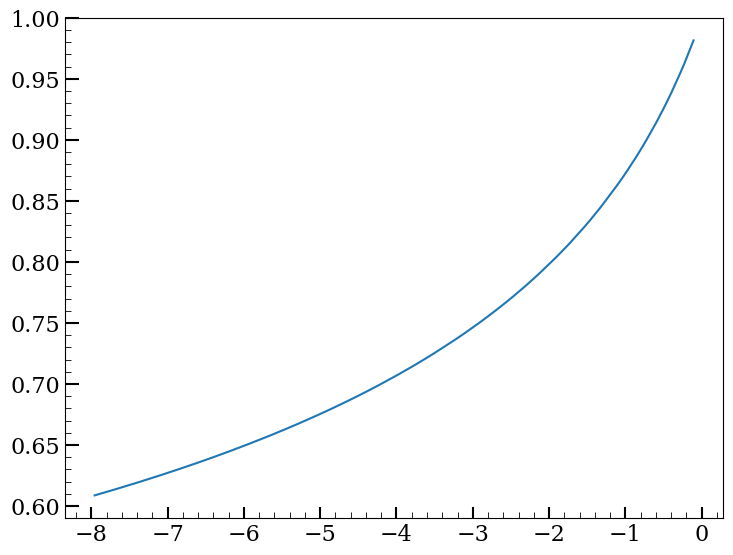

In [2]:
np.random.seed(42) #Keeping the seed for reproducibility


x_prime_dstrn_train = np.sort(np.random.uniform(-8.0, -0.0016, 200)) 
# Training data from uniform distribution
x_prime_dstrn_test = np.sort(np.random.uniform(-8.0, -0.0016, 200))

target_train = special.hyp2f1(1/3, 1, 11/6, x_prime_dstrn_train)
target_test = special.hyp2f1(1/3, 1, 11/6, x_prime_dstrn_test)

plt.plot(x_prime_dstrn_train, target_train)

#hypergeom function defined only for x < 0, the limiting values are 1 and 0 (later on we try to achieve these)

In [142]:
# Define problem for SR optimization, PyOperon works best with RMSE.
# The main constraining parameter is time (in sec), so the other
# parameters are set to very high values, so that the optimization
# is not limited by them.
# The maximum length of the expression is set to 50, which is a common value

hypergeom_args = {
    'allowed_symbols': "add,sub,mul,aq,constant,variable",
    'epsilon': 1e-5,
    'objectives': ['rmse', 'length'],
    'max_evaluations': int(1e16),
    'generations': int(1e16),
    'max_length': 50,
    'max_time': 60*5,
    'n_threads': 12,
    'tournament_size':2
}

Problem_hypergeom = Problem("Hypergeometric Function Problem", (x_prime_dstrn_train, target_train), (x_prime_dstrn_test, target_test), hypergeom_args)

In [143]:
# Solve the problem using PyOperon

Problem_hypergeom.solve()
print(f"number of solutions: {len(Problem_hypergeom.solutions)}")

[0.02626180648803711, 5.0], 194.46, (0.900047898293 + (0.070698834956 * (0.586383700371 * X1))), 0.00
[0.006139080505818129, 7.0], 204.50, (0.966380596161 + ((-0.248454153538) * (((-0.356151163578) * X1) / (sqrt(1 + (0.220932960510 * X1) ^ 2))))), 0.00
[0.0018124602502211928, 9.0], 209.72, (0.988940417767 + ((-0.693091392517) * (((-2.216795921326) * X1) / (sqrt(1 + ((2.721362829208 * X1) - 10.737044334412) ^ 2))))), 0.00
[0.0004244284355081618, 11.0], 214.99, (0.996422350407 + (0.180716216564 * ((0.052120726556 * X1) + ((2.237839698792 * X1) / (sqrt(1 + (((-0.978489518166) * X1) - (-2.427619218826)) ^ 2)))))), 0.00
[0.00022776892001274973, 13.0], 213.82, (0.383914411068 + (0.547462880611 * (((-0.195687338710) / (sqrt(1 + (0.457503795624 * X1) ^ 2))) + (11.330582618713 / (sqrt(1 + (((-1.998005509377) * X1) + 8.543338775635) ^ 2)))))), 0.00
[8.6981788626872e-05, 15.0], 220.32, (0.547623932362 + (0.141143620014 * (((-0.283046007156) / (sqrt(1 + (0.707795858383 * X1) ^ 2))) + ((0.052120726

<Axes: title={'center': 'Hypergeometric Function Problem: solution 3 Train'}>

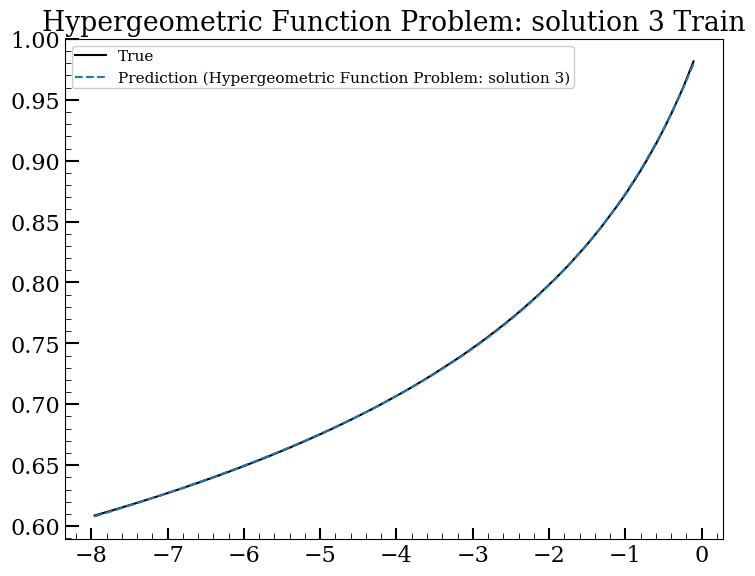

In [144]:
# Display and iterate through the solutions

Problem_hypergeom.solutions[3].plot_results()

In [ ]:
# Defining the metric that we want look at,
# in this case it is the fractional error of the hypergeometric function

coeff = [1/3, 1, 11/6]  
# Coefficients for the hypergeometric function for the growth factor
x_val = -1.0 * np.geomspace(10**(-7),10**7, 10000)
# Geomspace, so on the logarithmic scale we have equal spacing
Problem_hypergeom.solutions[-1].plot_fractional_error_hypergeom(x_val, coeff)


#plt.savefig("/home/danielct/Pictures/oxford_internship/fractional_error_growth_factor_5min_run_sol_5.pdf", dpi=300, bbox_inches='tight')

<Axes: title={'center': 'Hypergeometric Function Problem - Length vs MSE (Pareto Front)'}, xlabel='Length', ylabel='MSE'>

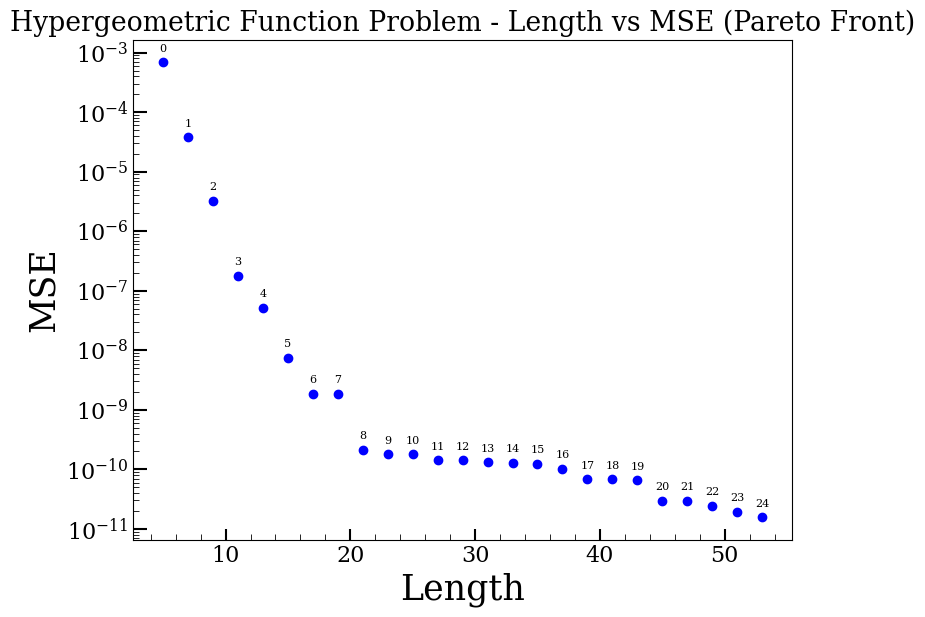

In [146]:
# Pareto front for the solutions

Problem_hypergeom.plot_l_vs_mse()

In [8]:
# Saving the solutions to LaTeX format for later use

Problem_hypergeom.export_solutions_to_latex(n=20)

LaTeX file written to latex_files/Hypergeometric_Function_Problemno_solutions_20/solutions.tex


In [151]:
# Iterating and displaying the solutions

k=4
Problem_hypergeom.solutions[k].display_expression()
b_vals = Problem_hypergeom.solutions[k].extract_and_format()[1]
b_vals

<IPython.core.display.Math object>

{'b0': 0.3839144110680195,
 'b1': 6.203073399441564,
 'b2': 3.992026015500869,
 'b3': 34.139275884386734,
 'b4': 73.98863743526454,
 'b5': 0.10713155414927655,
 'b6': 0.20930972301036377}

In [153]:
# Computing the limits of our approximation
# Once again, the limiting values are 1 (for x --> 0) and 0 (x --> -inf)

Problem_hypergeom.solutions[k].compute_limits(0).evalf(), Problem_hypergeom.solutions[k].compute_limits(-np.inf).evalf()

In [ ]:
# Defining class that will for now be storing expressions for another 
# analysis and reoptimization of the solution

from BesselML import Promising_solution
Promising_solution_0_limits = Promising_solution(Problem_hypergeom.solutions[k].sympy_expr, (x_prime_dstrn_train, target_train), Problem_hypergeom.solutions[k], b_vals)

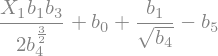

In [155]:
# Computing expansion at x = 0 up to two order terms (n=2)
# This part is crucial, as for some solutions (pow, log)  quite often the 
# expansion cannot be computed. 

expansion = Promising_solution_0_limits.compute_expansion_at_val(0, n=2)
expansion

In [156]:
# Automatically generating constraints from the expansion,
# so that the absolute and linear terms correspond to those
# computed analytically for this hypergeometric function

constraints, const_term, linear_term = Promising_solution_0_limits.generate_constraints_from_expansion()

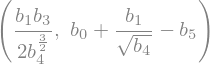

In [157]:
linear_term, const_term

In [158]:
# Reoptimising with the constraints defined above

Promising_solution_0_limits.optimisation(constraints_eq=constraints)

/home/danielct/Desktop/Internship_Oxford_2025/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`xtol` termination condition is satisfied.
Number of iterations: 726, function evaluations: 8976, CG iterations: 2205, optimality: 3.20e-07, constraint violation: 0.00e+00, execution time: 1.4e+01 s.

Optimization summary:
Parameter | Old Value | New Value | Abs Difference
--------- | --------- | --------- | --------------
b0        | 0.383914  | 0.299347  | 0.084567      
b1        | 6.20307   | 6.45012   | 0.24705       
b2        | 3.99203   | 0.811431  | 3.1806        
b3        | 34.1393   | 35.538    | 1.39872       
b4        | 73.9886   | 73.5183   | 0.470289      
b5        | 0.107132  | 0.0516112 | 0.0555204     
b6        | 0.20931   | 0.404429  | 0.19512       



(0.299347378112537 + 6.45012334199637/sqrt(0.811430672584338*X1**2 - 35.537993306086*X1 + 73.5183485724031) - 0.0516111512851495/sqrt(0.404429339586366*X1**2 + 1),
 {'b0': np.float64(0.29934737811253653),
  'b1': np.float64(6.450123341996372),
  'b2': np.float64(0.8114306725843375),
  'b3': np.float64(35.53799330608601),
  'b4': np.float64(73.51834857240313),
  'b5': np.float64(0.05161115128514948),
  'b6': np.float64(0.40442933958636645)},
 {'b0': np.float64(0.08456703295548296),
  'b1': np.float64(0.24704994255480806),
  'b2': np.float64(3.1805953429165315),
  'b3': np.float64(1.3987174216992742),
  'b4': np.float64(0.47028886286140903),
  'b5': np.float64(0.05552040286412707),
  'b6': np.float64(0.19511961657600269)})

<Axes: xlabel='$-x$', ylabel='Fractional Error'>

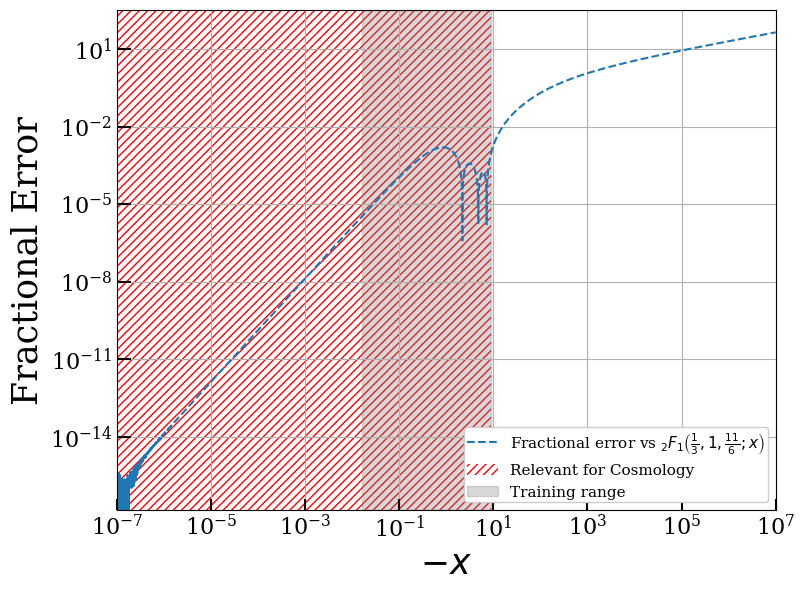

In [159]:
Promising_solution_0_limits.plot_fractional_error_hypergeom(x_val, coeff)

In [160]:
import sympy as sp
str(Promising_solution_0_limits.sympy_expr)
#Promising_solution_0_limits.sympy_expr

'b0 + b1/sqrt(X1**2*b2 - X1*b3 + b4) - b5/sqrt(X1**2*b6 + 1)'

In [ ]:
# Modification for the upper limit is not implemented automatically,
# (very hard), so we have to do it manually.

#manual = 'b1 / (X1**2*b2 - (X1*b3 / sqrt(X1**2*b4 + 1)) + (b5 / (X1**2*b4 + 1)) + 1)**(1/6)'
manual_run_III = 'b1/sqrt(X1**2*b2 - X1*b3 + b4)**(1/3) - b5/sqrt(X1**2*b6 + 1)**(1/3)'
#manual = str(Promising_solution_0_limits.sympy_expr)


# Another computation of the expansion, so that new constraint and parameters
# are updated

from BesselML import Promising_solution
#Manual_limiting_test = Promising_solution(sp.parsing.sympy_parser.parse_expr(manual),  (x_prime_dstrn_train, target_train), Promising_solution_0_limits.modified_parameters)
Manual_limiting_test = Promising_solution(sp.parsing.sympy_parser.parse_expr(manual_run_III),  (x_prime_dstrn_train, target_train), Promising_solution_0_limits.original_solution, initial_parameters=Promising_solution_0_limits.modified_parameters)
constraints_man, const_term_man, linear_term_man = Manual_limiting_test.generate_constraints_from_expansion()

In [209]:
def create_arbitrary_constraint(expression_string: str, 
                                target_value: float, 
                                full_param_symbols: List[sp.Symbol],
                                constraint_type: str = 'eq') -> Dict[str, Any]:
    """Creates a single, correctly formatted and numerically robust constraint.

    This helper function takes a user-defined mathematical expression as a string
    and converts it into a constraint dictionary. The function it returns is
    "defensive," meaning it will catch numerical errors (inf/NaN) and return a
    large penalty, preventing the optimizer from crashing.

    Args:
        expression_string (str):
            The mathematical condition, e.g., "b1 + b2" or "b3 / b4".
        target_value (float):
            The value the expression should be constrained against.
        full_param_symbols (List[sp.Symbol]):
            The complete, ordered list of sympy.Symbol objects being used in the
            main optimization routine.
        constraint_type (str, optional):
            The type of constraint, 'eq' (equality) or 'ineq' (inequality).
            Defaults to 'eq'.

    Returns:
        Dict[str, Any]: A constraint dictionary ready for `scipy.optimize.minimize`.
    """
    if constraint_type not in ['eq', 'ineq']:
        raise ValueError("constraint_type must be either 'eq' or 'ineq'.")
        
    local_symbol_dict = {str(s): s for s in full_param_symbols}
    parsed_expr = sp.parse_expr(expression_string, local_dict=local_symbol_dict)
    constraint_expr = parsed_expr - target_value
    constraint_lambda = sp.lambdify(full_param_symbols, constraint_expr, 'numpy')
    
    # --- DEFENSIVE CONSTRAINT FUNCTION ---
    # This wrapper function will be the actual constraint passed to the optimizer.
    def defensive_fun(b_values):
        try:
            # Use errstate to treat numpy warnings as errors
            with np.errstate(all='raise'):
                # Calculate the constraint violation
                violation = constraint_lambda(*b_values)
                
                # If the result is not a finite number, this region is invalid.
                if not np.isfinite(violation):
                    # For constraints, returning a large value indicates a large violation.
                    return 1e12 
                
                return float(violation)

        except (FloatingPointError, ValueError, ZeroDivisionError):
            # If any numerical error occurs, penalize this parameter set heavily.
            return 1e12

    # Return the final constraint dictionary with the robust function.
    return {
        'type': constraint_type,
        'fun': defensive_fun
    }


manual_expression_string = "b1/b2**(1/6) - b5/b6**(1/6)"
manual_target_value =  1.437283088461

full_param_symbols = [sp.Symbol(f'b{i}') for i in range(1,7)]
print(full_param_symbols)
parameter_limit_inf_constraint = create_arbitrary_constraint(manual_expression_string, manual_target_value, full_param_symbols ,constraint_type='eq')

constraints_man.append(parameter_limit_inf_constraint)

[b1, b2, b3, b4, b5, b6]


In [220]:
# We can create dummy initialisation parameters, 
# if those modified produce suboptimal results, but
# check if the b

initial_params_second_opt = {
    'b1': 1.0,
    'b2': 1.0,
    'b3': 1.0,  # Start smaller for nested terms
    'b4': 10,
    'b5':1.0,
    'b6':10.0
}
Manual_limiting_test.optimisation( constraints_eq=constraints_man)

/home/danielct/Desktop/Internship_Oxford_2025/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`gtol` termination condition is satisfied.
Number of iterations: 5327, function evaluations: 46270, CG iterations: 12552, optimality: 8.52e-09, constraint violation: 5.11e-15, execution time: 7e+01 s.

Optimization summary:
Parameter | Old Value | New Value | Abs Difference
--------- | --------- | --------- | --------------
b1        | 6.45012   | 2.26972   | 4.18041       
b2        | 0.811431  | 5.07437   | 4.26294       
b3        | 35.538    | 60.3473   | 24.8093       
b4        | 73.5183   | 62.9515   | 10.5668       
b5        | 0.0516112 | 0.137986  | 0.086375      
b6        | 0.404429  | 0.0106544 | 0.393775      



(2.26971520882365/(5.07436857399199*X1**2 - 60.3473114455416*X1 + 62.9515376844668)**(1/6) - 0.137986152186149/(0.0106544182417061*X1**2 + 1)**(1/6),
 {'b1': np.float64(2.2697152088236527),
  'b2': np.float64(5.074368573991986),
  'b3': np.float64(60.3473114455416),
  'b4': np.float64(62.95153768446677),
  'b5': np.float64(0.13798615218614946),
  'b6': np.float64(0.010654418241706057)},
 {'b1': np.float64(4.180408133172719),
  'b2': np.float64(4.262937901407649),
  'b3': np.float64(24.80931813945559),
  'b4': np.float64(10.566810887936356),
  'b5': np.float64(0.08637500090099998),
  'b6': np.float64(0.3937749213446604)})

<Axes: xlabel='$-x$', ylabel='Fractional Error'>

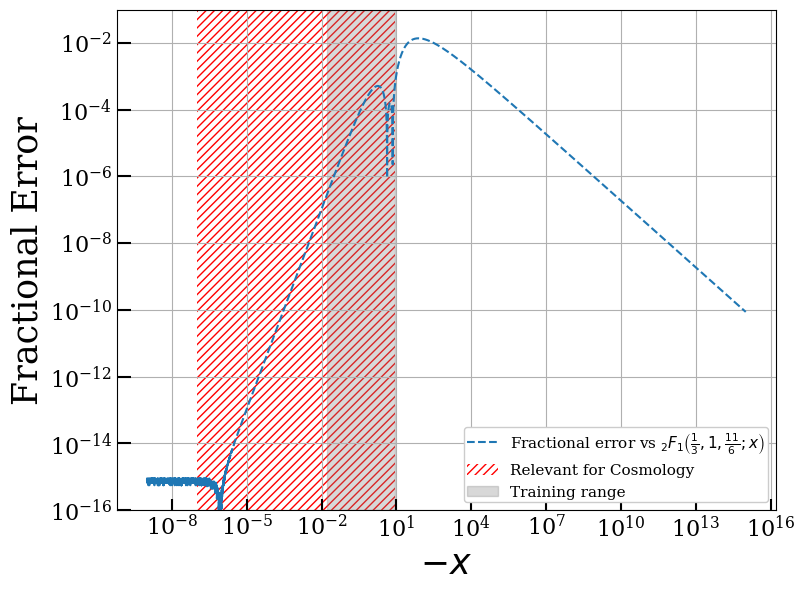

In [223]:
x_validation = -1.0 * np.geomspace(10**(-9),10**15, 10000)

Manual_limiting_test.plot_fractional_error_hypergeom(x_validation, coeff)

----------- Multidimensional optimisation ----------------

In [ ]:
# Latin Hypercube Sampling Example for comoving distance (flat universe, negligible radiation), optimising based w.t.s. to redshift and omega_matter
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=200)

l_bound = [0, 0.1]
u_bound = [3, 0.5]

sample = qmc.scale(sample, l_bound, u_bound)
sample

In [ ]:
# Generating training data for comoving distance


from scipy.integrate import quad
from typing import Tuple


def comoving_distance(params: Tuple[float, float]) -> float:

    z, omega_m = params
    if z < 0 or not (0 < omega_m < 1):
        raise ValueError("Invalid input: z must be >= 0 and 0 < omega_m < 1")

    def inv_E(z_prime):
        return 1.0 / np.sqrt(omega_m * (1 + z_prime)**3 + (1 - omega_m))

    integral, _ = quad(inv_E, 0, z)
    D_C =  integral  # in Mpc
    return D_C

comoving_distances = np.array([comoving_distance(sample[i]) for i in range(len(sample))])

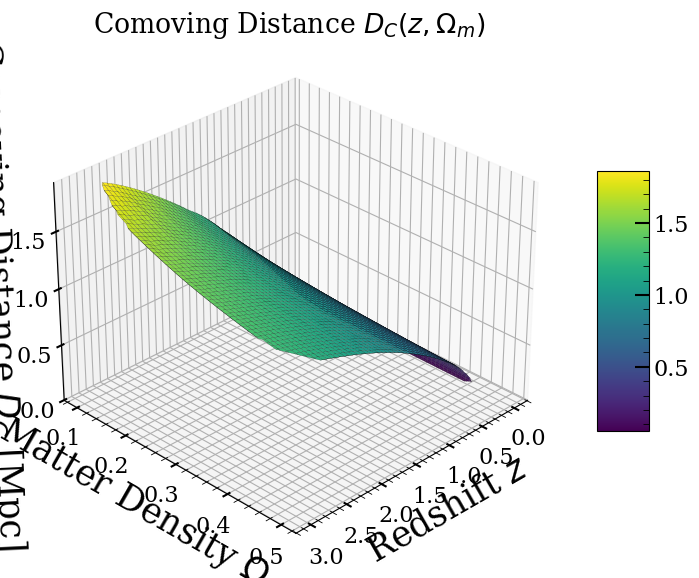

In [ ]:
# Plotting the comoving distance as a function of redshift and matter density
# Just for visualize intuition

from scipy.interpolate import griddata

# Create grid
z_lin = np.linspace(sample[:, 0].min(), sample[:, 0].max(), 100)
omega_m_lin = np.linspace(sample[:, 1].min(), sample[:, 1].max(), 100)
Z_grid, OmegaM_grid = np.meshgrid(z_lin, omega_m_lin)

# Interpolate the scattered data onto the grid
D_C_grid = griddata(sample, comoving_distances, (Z_grid, OmegaM_grid), method='cubic')

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Z_grid, OmegaM_grid, D_C_grid,
                       cmap='viridis', edgecolor='k', linewidth=0.1)

ax.set_xlabel('Redshift $z$')
ax.set_ylabel('Matter Density $\\Omega_m$')
ax.set_zlabel('Comoving Distance $D_C$ [Mpc]')
ax.set_title('Comoving Distance $D_C(z, \\Omega_m)$')
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()


In [ ]:
# Problem problem initalisation

name = "comoving distance 2d problem"

d2_args = {
    'allowed_symbols': "add,sub,mul,pow,aq,constant,log,exp,variable",
    'epsilon': 1e-5,
    'objectives': ['mse', 'length'],
    'max_evaluations': int(1e16),
    'generations': int(1e16),
    'max_length': 50,
    'max_time': 60*5,
    'n_threads': 12,
}

Problem_comoving_distance = Problem(name, (sample, comoving_distances), (sample, comoving_distances), d2_args)

In [ ]:
Problem_comoving_distance.solve()

Training data has multiple dimensions, fitting directly.
[0.017210014164447784, 5.0], 198.64, (0.184921100736 + ((-0.498270690441) * ((-1.036184310913) * X1))), 0.02
[0.013819927349686623, 6.0], 205.36, (2.476457595825 + ((-2.439133882523) * exp(((-0.346306473017) * X1)))), 0.01
[0.0014438630314543843, 7.0], 211.43, (2.287428617477 + ((-2.231162309647) * ((0.287036806345 * X2) ^ (0.150959908962 * X1)))), 0.00
[0.0013097182381898165, 8.0], 216.37, (3.950957775116 + ((-1.436923861504) * exp(((0.290108084679 * X2) ^ (0.090986534953 * X1))))), 0.00
[0.0009672812884673476, 9.0], 220.38, (2.181011915207 + ((-2.229234933853) * (((0.485346198082 * X2) ^ (0.208051398396 * X1)) / (sqrt(1 + (0.900992333889 * X2) ^ 2))))), 0.00
[7.332584937103093e-05, 10.0], 219.85, (0.986938476562 + ((-1.001623153687) * (exp(((-0.897887527943) * X1)) + (((-0.416065424681) * X1) / (sqrt(1 + (6.526662826538 * X2) ^ 2)))))), 0.00
[6.640525680268183e-05, 11.0], 224.31, (0.010433965363 + ((-0.646047830582) * ((((-1.06

In [ ]:
n=2
Problem_comoving_distance.solutions[n].extract_and_format(), Problem_comoving_distance.solutions[n].display_expression() 

<IPython.core.display.Math object>

(('- X_{2}^{X_{1}·b_{2}}·b_{0}·b_{1}^{X_{1}·b_{2}} + b_{3}',
  {'b0': 2.231162309647061,
   'b1': 0.28703680634498596,
   'b2': 0.15095990896199396,
   'b3': 2.2874286174769622},
  -X2**(X1*b2)*b0*b1**(X1*b2) + b3),
 None)

<Axes: title={'center': 'comoving distance 2d problem - Length vs MSE (Pareto Front)'}, xlabel='Length', ylabel='MSE'>

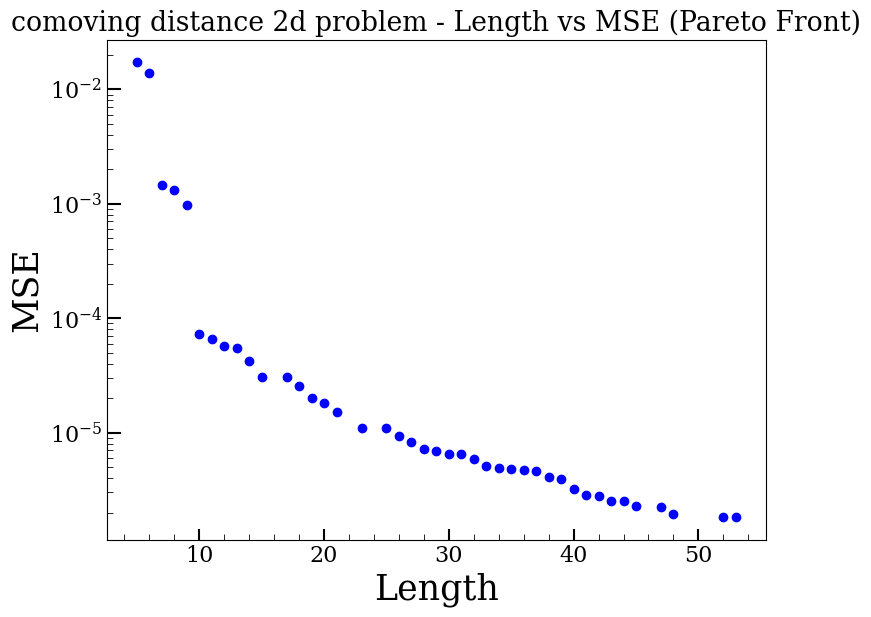

In [ ]:
# Pareto front for the solutions

Problem_comoving_distance.plot_l_vs_mse()